## Importar librerias

In [333]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import truncnorm

## Leer dataset

In [334]:
df = pd.read_csv("unclean_smartwatch_health_data.csv")

## Acerca del dataset
Este dataset simula resultados relacionados con la salud de los usuarios de un reloj inteligente (smartwatch).

https://www.kaggle.com/datasets/mohammedarfathr/smartwatch-health-data-uncleaned

### Descripcion de columnas
- **User ID**: identificador unico para cada usuario de smartwatch.
- **Heart Rate (BPM)**: frecuencia cardíaca del usuario en pulsaciones por minuto
- **Blood Oxygen Level (%)**: porcentaje de saturación de oxígeno en la sangre
- **Step-Count**: numero de pasos por dia
- **Sleep Duration (hours)**: duracion total de tiempo de sue;o en horas
- **Activity Level**: nivel de actividad categorizado como sedentario, activo o altamente activo
- **Stress Level**: Calificación de estrés subjetivo de 1 a 10

## Eliminar registros duplicados

In [335]:
df = df.drop_duplicates()

In [336]:
df.shape

(10000, 7)

In [337]:
df

,User ID,Heart Rate (BPM),Blood Oxygen Level (%),Step Count,Sleep Duration (hours),Activity Level,Stress Level
0,4174.0,58.939776,98.809650,5450.390578,7.167235622316564,Highly Active,1
1,NaN,NaN,98.532195,727.601610,6.538239375570314,Highly_Active,5
2,1860.0,247.803052,97.052954,2826.521994,ERROR,Highly Active,5
3,2294.0,40.000000,96.894213,13797.338044,7.367789630207228,Actve,3
4,2130.0,61.950165,98.583797,15679.067648,NaN,Highly_Active,6
...,...,...,...,...,...,...,...
9995,1524.0,78.819386,98.931927,2948.491953,7.402748595032027,Active,7
9996,4879.0,48.632659,95.773035,4725.623070,6.3821659358529015,Sedentary,2
9997,2624.0,73.834442,97.945874,2571.492060,6.91654920303435,Sedentary,4
9998,4907.0,NaN,98.401058,3364.788855,5.691233932149209,Active,8


## Renombrar columnas

In [338]:
df.columns

Index(['User ID', 'Heart Rate (BPM)', 'Blood Oxygen Level (%)', 'Step Count',
       'Sleep Duration (hours)', 'Activity Level', 'Stress Level'],
      dtype='object')

In [339]:
df.columns = ["user_id", "heart_rate", "blood_oxygen_level", "step_count",
       "sleep_duration", "activity_level", "stress_level"]

## Limpiar registros del dataset

### Eliminar registros que tengan celdas con valores nulos

In [340]:
"""
for c in df.columns:
    df = df.dropna( subset = [c] )
"""

'\nfor c in df.columns:\n    df = df.dropna( subset = [c] )\n'

### Reemplazar celdas con "NaN" user_id

In [341]:
id = np.max(df.loc[ (~(pd.isna(df["user_id"]))) , ["user_id"] ].astype("int64"))

In [342]:
df.loc[ (pd.isna(df["user_id"])), ["user_id"] ] = ++id
df["user_id"] = df["user_id"].astype("int64")

### Asignar valor 9 a celdas con "Very High" en columna stress_level

In [343]:
df["stress_level"] = df["stress_level"].replace("Very High", "9")

### Reemplazar registros con "NaN" o "ERROR" en algunas columnas

In [344]:
cols = ["sleep_duration", "heart_rate", "blood_oxygen_level", "step_count", "stress_level"]

In [345]:
random.seed(333)

In [346]:
for col in cols:
    data_series = pd.Series(df.loc[ (~(df[col] == "ERROR")) , col ].astype("float64").to_list())

    Q1 = data_series.quantile(0.25)
    Q3 = data_series.quantile(0.75)

    IQR = Q3 - Q1

    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR

    new_value = random.uniform(lower_bound, upper_bound)

    df.loc[
        (pd.isna(df[col]))
        | (df[col] == "ERROR")
        ,
        col
    ] = new_value

    df[col] = df[col].astype("float64")

### Columna stress_level como categorica

In [347]:
df["stress_level"] = df["stress_level"].astype("int64").astype("str")

### Correjir valores en celdas para columna "Activity Level"

In [348]:
df["activity_level"] = df["activity_level"].str.replace("_", " ")
df["activity_level"] = df["activity_level"].str.replace("Seddentary", "Sedentary")
df["activity_level"] = df["activity_level"].str.replace("Actve", "Active")

### Reemplazar celdas con "NaN" en Activity Level

In [349]:
activity_levels = ["Active", "Highly Active", "Sedentary"]
activity_level_n = pd.DataFrame()

for c in activity_levels:
    activity_level_n = pd.concat([
        activity_level_n
        ,
        pd.DataFrame({
            "name": [c]
            , "prob": [
                df.loc[
                    (~(pd.isna(df["activity_level"])))
                    & (df["activity_level"] == c)
                    ,
                    ["activity_level"]
                ].groupby(
                    ["activity_level"]
                    , as_index = False
                ).agg({
                    "activity_level": "count"
                }).iloc[0].iloc[0] / df.loc[ (~(pd.isna(df["activity_level"]))), : ].shape[0]
            ]
        })
    ])

In [350]:
activity_level_n

,name,prob
0,Active,0.333163
0,Highly Active,0.326735
0,Sedentary,0.340102


In [351]:
probs = activity_level_n["prob"].to_list()
activity_levels = activity_level_n["name"].to_list()

df.loc[ (pd.isna(df["activity_level"])), ["activity_level"] ] = np.random.choice(activity_levels, p = probs)

In [352]:
df.shape

(10000, 7)

In [353]:
for c in df.columns:
    df = df.dropna( subset = [c] )

In [354]:
df.shape

(10000, 7)

In [355]:
df

,user_id,heart_rate,blood_oxygen_level,step_count,sleep_duration,activity_level,stress_level
0,4174,58.939776,98.809650,5450.390578,7.167236,Highly Active,1
1,4999,63.113985,98.532195,727.601610,6.538239,Highly Active,5
2,1860,247.803052,97.052954,2826.521994,6.958067,Highly Active,5
3,2294,40.000000,96.894213,13797.338044,7.367790,Active,3
4,2130,61.950165,98.583797,15679.067648,6.958067,Highly Active,6
...,...,...,...,...,...,...,...
9995,1524,78.819386,98.931927,2948.491953,7.402749,Active,7
9996,4879,48.632659,95.773035,4725.623070,6.382166,Sedentary,2
9997,2624,73.834442,97.945874,2571.492060,6.916549,Sedentary,4
9998,4907,63.113985,98.401058,3364.788855,5.691234,Active,8


## Obtener columnas numericas y categoricas

In [356]:
cat_cols = [ c for c in df.columns if df[c].dtypes == "O" ]
num_cols = [ c for c in df.columns if df[c].dtypes == "int64" or df[c].dtypes == "float64" ]

In [357]:
cat_cols

['activity_level', 'stress_level']

In [358]:
num_cols.remove("user_id")

num_cols

['heart_rate', 'blood_oxygen_level', 'step_count', 'sleep_duration']

# Distribucion de variables numericas

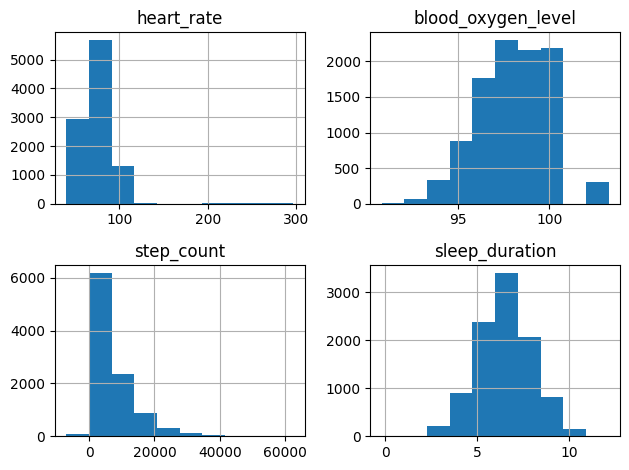

In [359]:
axes = df[num_cols].hist()

for ax in axes.flatten():
    ax.set_title(ax.get_title()) 
    ax.set_xlabel(ax.get_xlabel())
    ax.set_ylabel(ax.get_ylabel())

plt.tight_layout()
plt.show()

# Obtener distribuciones de las columnas categoricas

In [360]:
prob_freq = df.groupby( cat_cols, as_index = False ).agg({
    "user_id": ["count"]
})

In [361]:
prob_freq.columns = cat_cols + ["user_id"]

In [362]:
prob_freq

,activity_level,stress_level,user_id
0,Active,1,333
1,Active,10,306
2,Active,2,317
3,Active,3,327
4,Active,4,332
5,Active,5,307
6,Active,6,377
7,Active,7,342
8,Active,8,296
9,Active,9,328


In [363]:
prob_freq["user_id"] = prob_freq["user_id"] / df.shape[0]

In [364]:
np.sum(prob_freq["user_id"])

np.float64(1.0)

# Visualizacion de valores atipicos

<Axes: title={'center': 'step_count'}, xlabel='activity_level'>

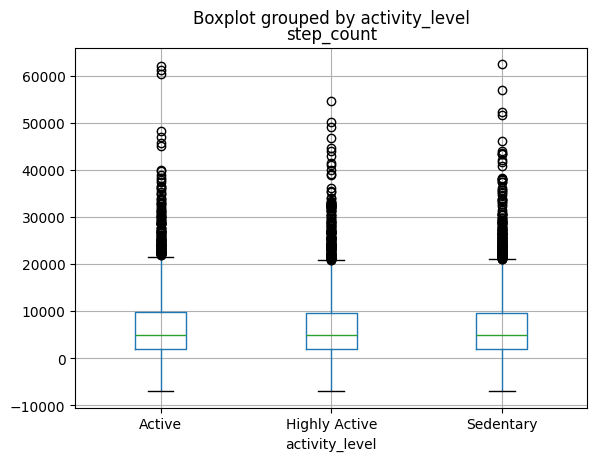

In [365]:
df.boxplot(
    column = "step_count",
    by = "activity_level"
)

<Axes: title={'center': 'heart_rate'}, xlabel='activity_level'>

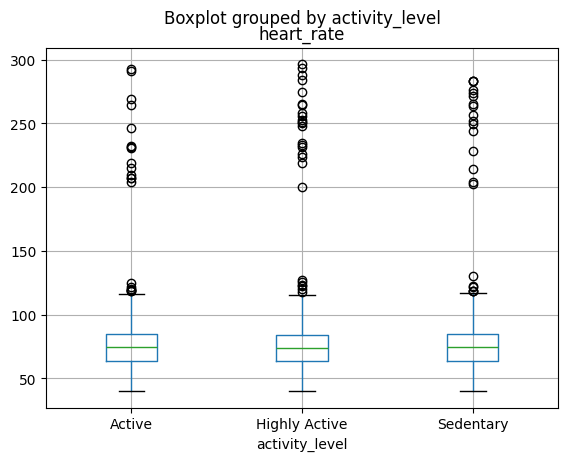

In [366]:
df.boxplot(
    column = "heart_rate",
    by = "activity_level"
)

<Axes: title={'center': 'blood_oxygen_level'}, xlabel='stress_level'>

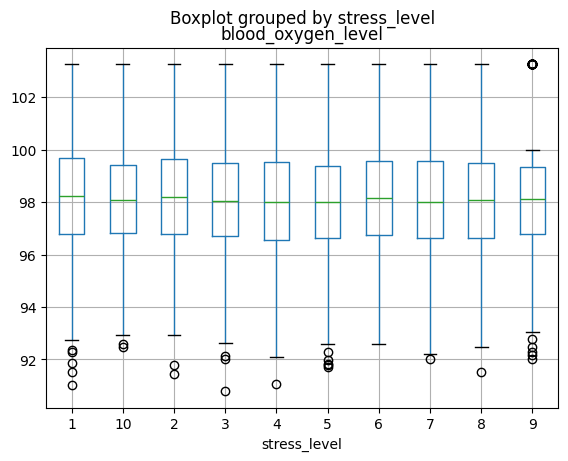

In [367]:
df.boxplot(
    column = "blood_oxygen_level",
    by = "stress_level"
)

<Axes: title={'center': 'sleep_duration'}, xlabel='stress_level'>

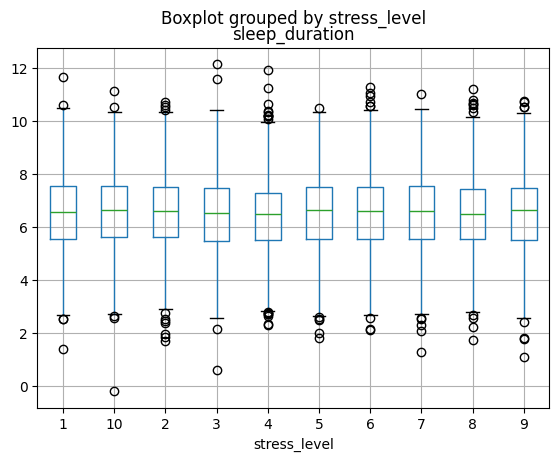

In [368]:
df.boxplot(
    column = "sleep_duration",
    by = "stress_level"
)

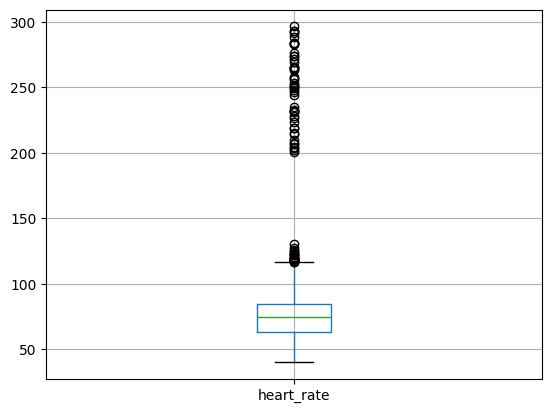

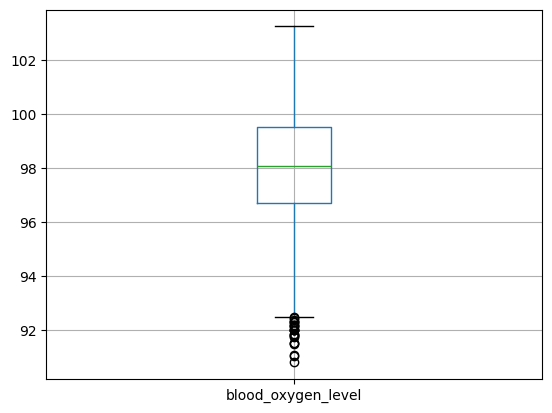

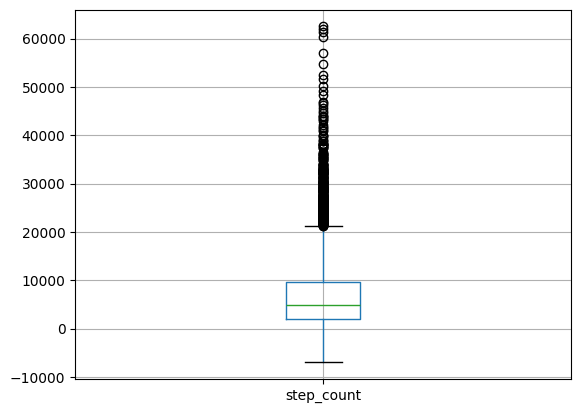

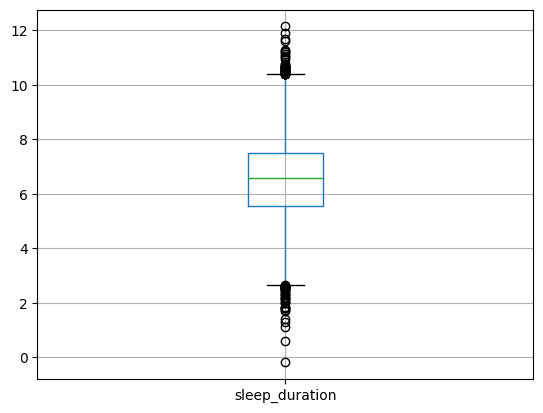

In [369]:
for c in num_cols:
    df.loc[ : , [c] ].boxplot()
    plt.show()

# Limpiar valores atipicos

In [370]:
transformations = {}
new_cols = []
for c in num_cols:
    transformations[c] = [ 
            ( "lower_bound" , lambda x: x.quantile(.25) - 1.5 * (x.quantile(.75) - x.quantile(.25))  )
            , ( "upper_bound" , lambda x: x.quantile(.75) + 1.5 * (x.quantile(.75) - x.quantile(.25))  )
    ]
    new_cols.append( f"{c}_lower_bound" )
    new_cols.append( f"{c}_upper_bound" )

In [371]:
df_resultados = df.groupby( cat_cols , as_index = False ).agg(transformations)

In [372]:
df_resultados.columns =  cat_cols + new_cols

In [373]:
df_resultados

,activity_level,stress_level,heart_rate_lower_bound,heart_rate_upper_bound,blood_oxygen_level_lower_bound,blood_oxygen_level_upper_bound,step_count_lower_bound,step_count_upper_bound,sleep_duration_lower_bound,sleep_duration_upper_bound
0,Active,1,29.247037,119.583827,92.206871,104.166686,-8610.335876,20178.707282,2.415429,10.759108
1,Active,10,35.201760,114.708898,92.577317,103.532225,-11533.305632,24209.451896,3.263980,9.657185
2,Active,2,30.388481,117.984855,92.498668,103.901132,-7988.652969,18518.307219,2.896092,10.197484
3,Active,3,31.394891,115.979142,92.814198,103.202921,-10766.577386,22758.877674,2.800341,10.318103
4,Active,4,31.356012,120.045284,91.759599,103.729296,-10539.408536,23017.426218,2.663069,10.277829
5,Active,5,33.766037,112.027231,92.541779,103.611924,-8593.431127,19270.496792,3.091361,10.050648
6,Active,6,35.105850,114.902706,92.445761,103.743133,-9172.238880,20891.018750,2.485158,10.454476
7,Active,7,29.951570,118.384677,92.276073,103.943935,-10689.043514,22626.823797,2.520834,10.645684
8,Active,8,32.487368,117.483321,92.006525,104.691669,-9150.560753,19677.467299,2.559135,10.288167
9,Active,9,32.263035,115.171657,92.927837,103.360998,-10712.678792,23635.292835,2.361968,10.425039


In [374]:
df_bound = df.merge(
    df_resultados
    , on = cat_cols
    , how = "inner"
)

In [375]:
for c in num_cols:
    df_bound = df_bound.loc[
        ( df_bound[c] > df_bound[f"{c}_lower_bound"] )
        &
        ( df_bound[c] < df_bound[f"{c}_upper_bound"] )
        ,
        :
    ]

In [376]:
df_bound

,user_id,heart_rate,blood_oxygen_level,step_count,sleep_duration,activity_level,stress_level,heart_rate_lower_bound,heart_rate_upper_bound,blood_oxygen_level_lower_bound,blood_oxygen_level_upper_bound,step_count_lower_bound,step_count_upper_bound,sleep_duration_lower_bound,sleep_duration_upper_bound
0,4174,58.939776,98.809650,5450.390578,7.167236,Highly Active,1,32.669368,115.969794,92.655163,103.829915,-8286.494353,18448.879352,2.778769,10.451488
1,4999,63.113985,98.532195,727.601610,6.538239,Highly Active,5,36.514469,111.108832,92.532659,103.201767,-8612.545285,20183.951510,2.419151,10.594836
3,2294,40.000000,96.894213,13797.338044,7.367790,Active,3,31.394891,115.979142,92.814198,103.202921,-10766.577386,22758.877674,2.800341,10.318103
4,2130,61.950165,98.583797,15679.067648,6.958067,Highly Active,6,32.315761,114.444358,92.518692,103.598857,-8239.253125,19429.930449,2.595647,10.395778
5,2095,96.285938,94.202910,10205.992256,8.378343,Highly Active,10,32.087716,114.865001,92.757779,103.471340,-9814.406148,22322.350380,2.441979,10.819564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1524,78.819386,98.931927,2948.491953,7.402749,Active,7,29.951570,118.384677,92.276073,103.943935,-10689.043514,22626.823797,2.520834,10.645684
9996,4879,48.632659,95.773035,4725.623070,6.382166,Sedentary,2,30.673421,117.181592,92.456971,104.016406,-8527.216872,18456.763368,2.626045,10.714421
9997,2624,73.834442,97.945874,2571.492060,6.916549,Sedentary,4,31.693872,118.141639,92.132291,103.986460,-9914.547397,22034.715341,2.897156,9.753735
9998,4907,63.113985,98.401058,3364.788855,5.691234,Active,8,32.487368,117.483321,92.006525,104.691669,-9150.560753,19677.467299,2.559135,10.288167


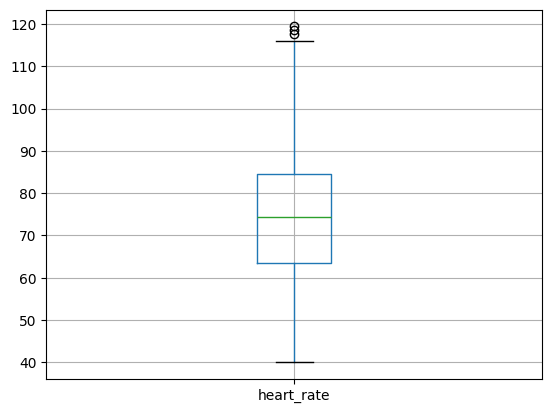

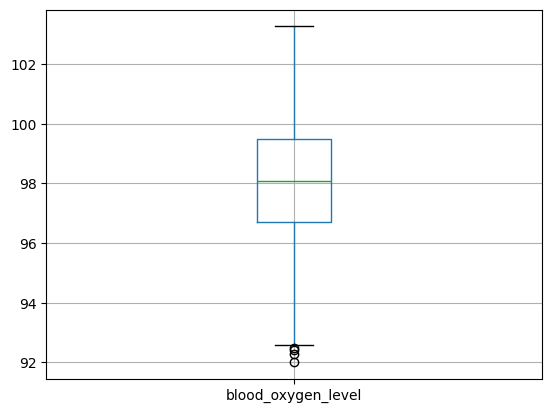

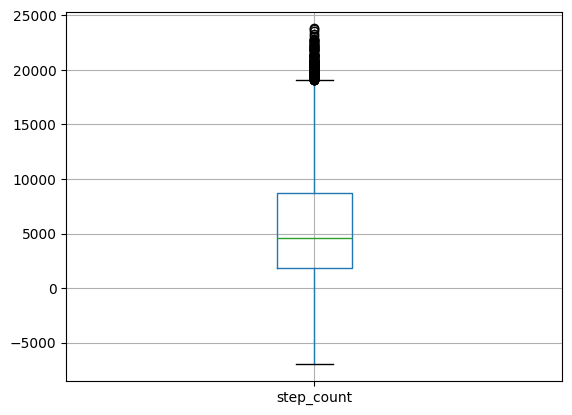

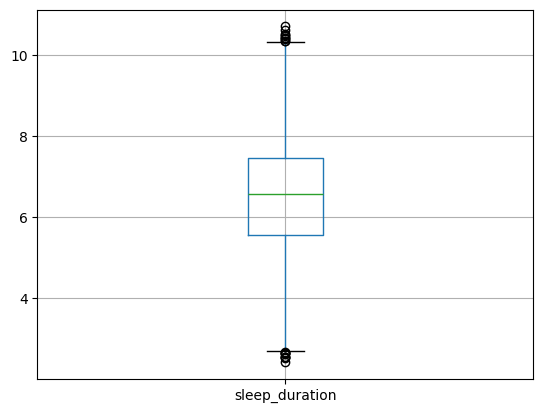

In [377]:
for c in num_cols:
    df_bound.loc[ : , [c] ].boxplot()
    plt.show()

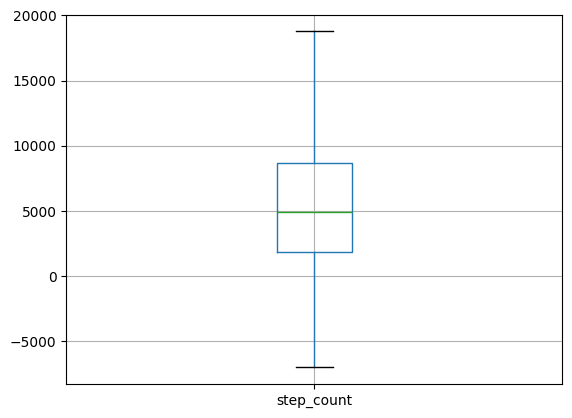

In [378]:
df_bound.loc[
    ( df_bound["activity_level"] == "Highly Active" )
    & ( df_bound["stress_level"] == "7" )
    , 
    ["step_count"]
].boxplot()

plt.show()

<Axes: title={'center': 'blood_oxygen_level'}, xlabel='activity_level'>

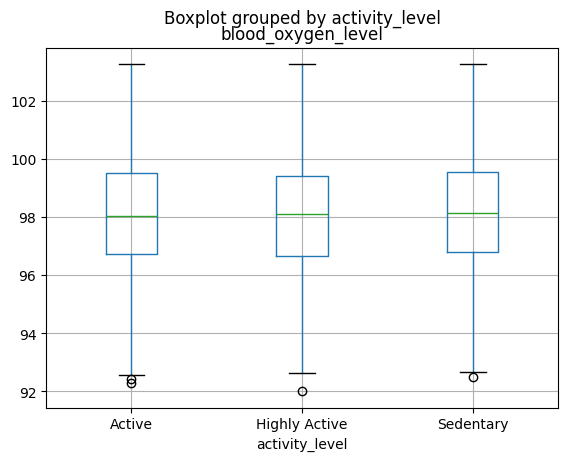

In [379]:
df_bound.boxplot(
    column = "blood_oxygen_level",
    by = "activity_level"
)

# Resumen estadistico para las columnas

In [380]:
df_clean = df_bound.loc[ : , cat_cols + num_cols ]

In [381]:
summ_aggregations = {}
cols_summ = []
for c in num_cols:
    summ_aggregations[c] = [ "min" , "max" , "mean" , "std" ]
    cols_summ.append( f"{c}_min" )
    cols_summ.append( f"{c}_max" )
    cols_summ.append( f"{c}_mean" )
    cols_summ.append( f"{c}_std" )

In [382]:
df_summ = df_clean.groupby(
    cat_cols
    , as_index=False
).agg(summ_aggregations)

In [ ]:
df_summ.columns = cat_cols +  cols_summ

In [398]:
df_summ.head(5)

,activity_level,stress_level,heart_rate_min,heart_rate_max,heart_rate_mean,heart_rate_std,blood_oxygen_level_min,blood_oxygen_level_max,blood_oxygen_level_mean,blood_oxygen_level_std,step_count_min,step_count_max,step_count_mean,step_count_std,sleep_duration_min,sleep_duration_max,sleep_duration_mean,sleep_duration_std
0,Active,1,40.0,119.424899,74.978870,15.471010,92.282996,103.262579,98.025029,1.950339,-7005.584859,19858.712771,6015.298871,5220.131169,2.660246,10.474966,6.552901,1.521589
1,Active,10,40.0,114.394654,75.523047,14.222000,92.952170,103.262579,97.931516,1.880781,-7005.584859,23804.963811,6289.635623,5692.406005,3.417136,9.507809,6.551387,1.273175
2,Active,2,40.0,110.877416,74.095684,14.517680,93.409684,103.262579,98.044384,1.850905,-7005.584859,18444.533090,5274.403342,4403.230304,3.386415,10.076560,6.573563,1.321913
3,Active,3,40.0,115.619162,73.830401,13.919730,93.620236,100.000000,97.809831,1.648755,-7005.584859,22632.768453,6005.576517,5767.763015,3.474583,10.104963,6.548638,1.392806
4,Active,4,40.0,115.411313,76.290843,15.061407,92.965872,103.262579,97.790268,1.962693,-7005.584859,22325.612431,6327.026167,5474.642875,2.710434,10.207206,6.522347,1.428694


# Expansion del DF final

In [383]:
prob_freq

,activity_level,stress_level,user_id
0,Active,1,0.0333
1,Active,10,0.0306
2,Active,2,0.0317
3,Active,3,0.0327
4,Active,4,0.0332
5,Active,5,0.0307
6,Active,6,0.0377
7,Active,7,0.0342
8,Active,8,0.0296
9,Active,9,0.0328


In [385]:
n = 100 * 1000
ids = np.random.choice( prob_freq.index , size = n, p = prob_freq["user_id"].to_list() )

In [386]:
def trunc_vector(min_val, max_val, media, desv_std, size):
    # Calcular los límites 'a' y 'b' para la función truncnorm
    a, b = (min_val - media) / desv_std, (max_val - media) / desv_std
    # Generar muestras de la distribución normal truncada
    muestras = truncnorm.rvs(a, b, loc=media, scale=desv_std, size=size)
    return muestras

In [387]:
dfextended = pd.DataFrame()
for i in prob_freq.index:
    setting = {
        "id": ids[ ids == i ]
    }
    for c in num_cols:
        setting[c] = trunc_vector( 
            df_summ.iloc[i][f"{c}_min"]
            , df_summ.iloc[i][f"{c}_max"]
            , df_summ.iloc[i][f"{c}_mean"]
            , df_summ.iloc[i][f"{c}_std"]
            , len( ids[ ids == i ] )
        )
    tmp = pd.DataFrame(setting)
    dfextended = pd.concat( [ dfextended , tmp ] )

In [388]:
prob_freq["id"] = prob_freq.index

In [389]:
final = prob_freq.loc[ : , ["id"] + cat_cols ].merge(
    dfextended
    , on = ["id"]
    , how = "inner"
)

# Comparacion DF clean y DF final

In [390]:
df_clean.groupby(
    cat_cols
    , as_index = False
).agg({
    'step_count': [ "min" , "max" , "mean" , "std" , "count" ]
}).iloc[16]

activity_level           Highly Active
stress_level                         6
step_count      min       -7005.584859
                max       19062.755209
                mean       5548.657477
                std        4637.642289
                count              394
Name: 16, dtype: object

In [391]:
final.groupby(
    cat_cols
    , as_index = False
).agg({
    'step_count': [ "min" , "max" , "mean" , "std" , "count" ]
}).iloc[16]

activity_level           Highly Active
stress_level                         6
step_count      min       -6948.622373
                max       19008.050847
                mean       5527.025733
                std        4568.714478
                count             4209
Name: 16, dtype: object

In [392]:
df.describe()

,user_id,heart_rate,blood_oxygen_level,step_count,sleep_duration
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,3047.509800,75.518603,98.004211,6845.773178,6.523431
std,1172.753667,19.188051,1.941127,6991.305930,1.482385
min,1001.000000,40.000000,90.791208,-7005.584859,-0.194453
25%,2016.000000,63.416088,96.703718,1954.281465,5.541519
50%,3040.000000,74.510573,98.092849,4899.902269,6.579024
75%,4072.250000,84.791711,99.517304,9680.097095,7.476227
max,4999.000000,296.593970,103.262579,62486.690753,12.140233


In [393]:
final.describe()

,id,heart_rate,blood_oxygen_level,step_count,sleep_duration
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,14.578000,74.790761,97.942362,5923.702723,6.521306
std,8.631162,13.853179,1.799020,4991.751578,1.368666
min,0.000000,40.001227,92.046824,-7005.378390,2.453477
25%,7.000000,65.068283,96.713474,2469.075465,5.572236
50%,15.000000,74.717210,97.937070,5850.940290,6.517141
75%,22.000000,84.380877,99.167740,9284.111495,7.469779
max,29.000000,119.251982,103.257748,23435.434899,10.684577


<Axes: title={'center': 'step_count'}, xlabel='activity_level'>

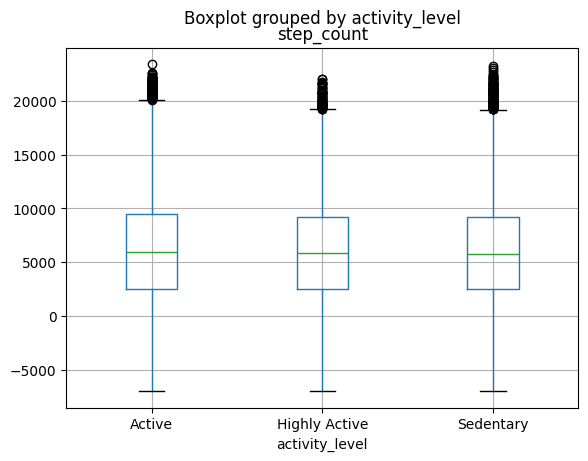

In [394]:
final.boxplot(
    column = "step_count",
    by = "activity_level"
)

<Axes: title={'center': 'blood_oxygen_level'}, xlabel='activity_level'>

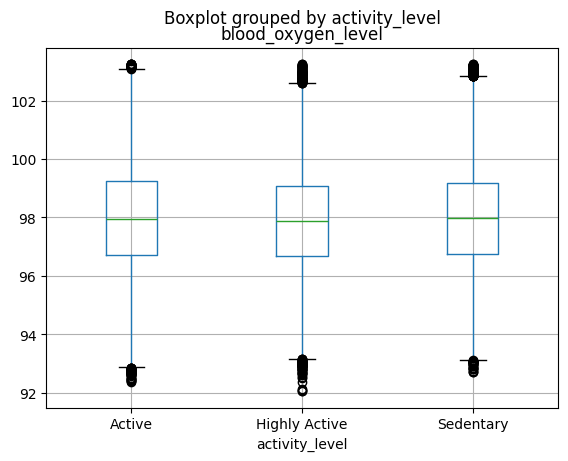

In [395]:
final.boxplot(
    column = "blood_oxygen_level",
    by = "activity_level"
)

<Axes: title={'center': 'heart_rate'}, xlabel='activity_level'>

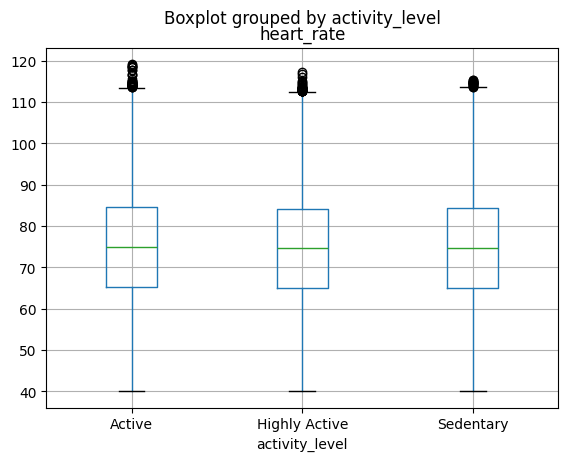

In [396]:
final.boxplot(
    column = "heart_rate",
    by = "activity_level"
)

- El percentil 50 para las columnas numericas en ambas categorias es muy similar
- La expansion se realizo adecuadamente dado que en el resumen estadistico del dataframe expandido se observan valores muy cercanos a los del dataframe original 